Дифференциальное уравнение для вертикального прогиба имеет вид:

\begin{equation}
\frac{d^4y}{dx^4} = - \frac{2}{I} \frac{dI}{dx}\cdot \frac{d^3y}{dx^3} - \frac{1}{I} \frac{d^2I}{dx^2}\cdot \frac{d^2y}{dx^2} + \frac{\omega}{EI},
\end{equation}

где $I(x)$ равняется:
\begin{equation}
I = 5(1 + 4e^{-\frac{6x}{l}})
\end{equation}

\begin{equation}
\frac{dI}{dx} = -\frac{120}{l}e^{-\frac{6x}{l}}
\end{equation}

\begin{equation}
\frac{d^2I}{dx^2} = \frac{720}{l}e^{-\frac{6x}{l}}
\end{equation}

Учтем, что $\frac{\omega}{EI} = 0$. 

Тогда исходное уравнение можно записать в следующем виде:

\begin{equation}
\frac{d^4y}{dx^4} = \frac{2}{5(1 + 4e^{-\frac{6x}{l}})} \cdot \frac{120}{l}e^{-\frac{6x}{l}} \cdot \frac{d^3y}{dx^3} - 
\frac{1}{5(1 + 4e^{-\frac{6x}{l}})} \cdot \frac{720}{l}e^{-\frac{6x}{l}} \cdot \frac{d^2y}{dx^2}
\end{equation}

Найдем значение длины балки: $l = 50\cdot x^*$, где $x^*$ - корень уравнения на промежутке $[1, 4]$:
\begin{equation}
\int_0^{20} \frac{e^{-0.9z}}{z+x}dz = 0.1957981\cdot x
\end{equation}

In [1]:
import math
import numpy as np
from scipy import integrate
from scipy.optimize import fsolve
import matplotlib.pyplot as plt

In [6]:
def fun(x: int):
    def inner(z: int):
        return math.exp(-0.9 * z)/(z + x)
    return integrate.quad(inner, 0, 20)[0] - 0.1957981 * x;

In [8]:
x_star, = fsolve(fun, 2)

l = 50 * x_star
print('Длина балки l = {0}'.format(l))

Длина балки l = 99.98477586023728


Начальные условия:

$y(0) = y'(0) = 0$,<br/>
$y''(0) = \frac{Pl}{75}\cdot 10^{-7}$,<br/>
$y'''(0) = \frac{P \cdot 3.8}{75}\cdot 10^{-7}$

In [3]:
def find_y0(p: int):
    y0_1 = 0
    y0_2 = 0
    y0_3 = p * l / 75 * 10 ** (-7)
    y0_4 = p * 3.8 / 75 * 10 ** (-7)
    return [y0_1, y0_2, y0_3, y0_4]

Произведем следующшие замены:

$x_1(t) = y(t)$,<br/>
$x_2(t) = y'(t)$,<br/>
$x_3(t) = y''(t)$,<br/>
$x_4(t) = y'''(t)$.<br/>

С их помощью исходное дифференциальное уравнение сводится к системе дифференциальных уравнений первого порядка:

\begin{equation}
\begin{pmatrix}
    x'_1(t) \\
    x'_2(t) \\
    x'_3(t) \\
    x'_4(t) \\
\end{pmatrix} =
\begin{pmatrix}
    0 & 1 & 0 & 0 \\
    0 & 0 & 1 & 0 \\
    0 & 0 & 0 & 1 \\
    0 & 0 & - \frac{1}{I} \frac{d^2I}{dx^2} & - \frac{2}{I} \frac{dI}{dx} \\
\end{pmatrix}
\cdot
\begin{pmatrix}
    x_1(t) \\
    x_2(t) \\
    x_3(t) \\
    x_4(t) \\
\end{pmatrix}
\end{equation}

In [12]:
def solvr(Y: np.array, t: float):
    a = -1 / (5 * (1 + 4 * math.exp(-6 * t/l))) * (720 * math.exp(-6 * t/l)) / l
    b = 2 / (5 * (1 + 4 * math.exp(-6 * t/l))) * (120 * math.exp(-6 * t/l)) / l
    y4 = a * Y[2] + b * Y[3]
    return [Y[1], Y[2], Y[3], y4]

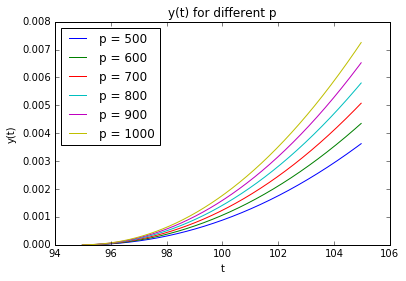

In [13]:
t = np.arange(l - 5, l + 5, 0.01)
values = []

for p in range(500, 1000 + 1, 100):
    y0 = find_y0(p)
    res = integrate.odeint(solvr, y0, t)
    y = np.transpose(res)[0]
    values.append(y)

    plt.plot(t, y, label='p = {0}'.format(p))

plt.legend(loc='upper left')
plt.xlabel('t')
plt.ylabel('y(t)')
plt.title('y(t) for different p')
plt.show()